# 6D Pose of the camera with with a board

The goal of this notebook is to determine 6D pose of the camera with respect to a board. The board is a custom pattern made with a AprilTags. These tags are at know positions and orientations, and therefore we can use them to determine cameras 6D pose(i.e. location and orientation in space). 

![BoardPoses](https://github.com/vitzeman/manim_vis/blob/main/visualization/MSV-Workshop/Board_view.png?raw=true)

# Preparation

As always we need to import some libraries and set up the environment. 

In [95]:
import json
import os
from pathlib import Path
import random

import open3d as o3d
import numpy as np

# import scipy.spatial.rotations as R
import cv2
import matplotlib.pyplot as plt

from tqdm import tqdm

## Visualization functions

In [ ]:
def cv2_imshow(bgr: np.ndarray) -> None:
    """Displays the image in jupyter notebook

    Converts the image from BGR to RGB format as cv2 uses BGR formatand matplotlib
    uses RGB format.


    Args:
        bgr (np.ndarray): Image in BGR format [H, W, C]
    """
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb)
    plt.show()


def visualize_tag_detection(
    image: np.ndarray,
    corners: list,
    ids: list = None,
    color: tuple = (0, 255, 0),
    width: int = 2,
) -> np.ndarray:
    """Visualize the detection of markers by outliying them in the image also indicating
    the first corner with a circle and the id of the marker.

    Returns a copt of the image so that the original image is not modified.

    Args:
        image (np.ndarray): Image in BGR format [H, W, C]
        corners (list): list of the detected corners of the markers in the image
        ids (list, optional): Ids of corresponding marker corners. Defaults to None.
        color (tuple, optional): Color of the outline. Defaults to Green.
        width (int, optional): Width of the outline. Defaults to 2.

    Returns:
        np.ndarray: Image with the detected markers outlined
    """
    out = image.copy()
    for e, corner in enumerate(corners):
        corner = np.int32(corner)
        # Tag circumference highlight
        cv2.polylines(out, corner, True, color, width)
        # Indicate the first corner by inputting a circle
        cv2.circle(out, (corner[0][0][0], corner[0][0][1]), 2 * width + 1, color, -1)
        if ids is not None:
            idx = ids[e]
            cv2.putText(
                out,
                str(idx[0]),
                (corner[0][0][0], corner[0][0][1]),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                color,
                width,
            )

    return out


def create_board_mesh(img_path: str, board_size: np.ndarray, name:str= "board") -> dict:
    """

    Args:
        img_path (str): Path to the image of the board to show the mesh
        board_size (np.ndarray): Real world size of the board in milimeters

    Returns:
        dict: _description_
    """

    # board_image_path = "data/board/board.png"
    board_image_path = img_path
    board_bgr = cv2.imread(board_image_path)
    board_rgb = cv2.cvtColor(board_bgr, cv2.COLOR_BGR2RGB)
    board_rgb = cv2.flip(board_rgb, 0)
    map_image = o3d.geometry.Image(board_rgb)

    # board_size = np.array(board_data["paper_size_mm"])
    half_size = board_size / 2
    left_top = np.array([-half_size[0], -half_size[1], 0])
    right_top = np.array([-half_size[0], half_size[1], 0])
    right_bot = np.array([half_size[0], half_size[1], 0])
    left_bot = np.array([half_size[0], -half_size[1], 0])

    vertices = np.array([left_top, right_top, right_bot, left_bot], dtype=np.float32)
    triangles = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int32)
    uvs = np.array([[0, 0], [1, 0], [1, 1], [0, 0], [1, 1], [0, 1]], dtype=np.float32)

    # Map the image to the camera pyramid
    texture_map = o3d.geometry.TriangleMesh()
    texture_map.vertices = o3d.utility.Vector3dVector(vertices)
    texture_map.triangles = o3d.utility.Vector3iVector(triangles)
    texture_map.triangle_uvs = o3d.utility.Vector2dVector(uvs)

    material = o3d.visualization.rendering.MaterialRecord()
    material.shader = "defaultUnlit"
    material.base_color = [1.0, 1.0, 1.0, 1.0]  # RGBA
    material.base_metallic = 0.0
    material.base_roughness = 1.0
    material.albedo_img = map_image

    board_image = {
        "name": name,
        "geometry": texture_map,
        "material": material,
    }
    return board_image

# NEED TO TEST THESE VISUALIZATIONS FuNCTIONS
def create_camera_pyramid(bgr:np.ndarray, cam_K:np.ndarray, Tmx:np.ndarray, name:str="camera") -> None:
    """Based on the camera intrinsics and rgb image creates the camera pyramid

    Adds visualization of the camera pyramid to the scene with the notch
    depicting the top of the image
    
    Args:
        bgr (np.ndarray): BGR image [HxWx3] 
        cam_K (np.ndarray): Camera intrinsics [3x3] matrix
    """ 
    h, w = bgr.shape[:2]
    camera_lineset = o3d.geometry.LineSet()
    camera_lineset = camera_lineset.create_camera_visualization(w,h,cam_K, Tmx, scale = 20)
    camera_lineset.paint_uniform_color([.2, .2, .2])
    camera_points = np.asarray(camera_lineset.points)

    # create top view of the pyramid
    left_top = camera_points[1,:]
    right_top = camera_points[2,:]
    right_bot = camera_points[3,:]
    left_bot = camera_points[4,:]
    height = np.abs(right_bot[1] - right_top[1])
    h = height * 0.33

    # Top Notch
    mid_width = (right_top[0] - left_top[0])/2
    notch_point = np.array([left_top[0] + mid_width, left_top[1] - h, left_top[2]])
    notch_points = np.array([left_top, right_top, notch_point])
    top_lineset = o3d.geometry.LineSet()
    top_lineset.points = o3d.utility.Vector3dVector(notch_points)
    top_lineset.lines = o3d.utility.Vector2iVector([[0, 2], [2,1]])
    top_lineset.paint_uniform_color([.2, .2, .2])

    # Add image to the camera pyramid
    img = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = cv2.flip(img, 0)
    map_image = o3d.geometry.Image(img)

    vertices = np.array([left_top, right_top, right_bot, left_bot], dtype=np.float32)
    triangles = np.array([[0, 1, 2], [0, 2, 3]], dtype=np.int32)
    uvs = np.array([[0, 0], [1, 0], [1, 1], [0,0], [1,1], [0,1]], dtype=np.float32)

    texture_map = o3d.geometry.TriangleMesh()
    texture_map.vertices = o3d.utility.Vector3dVector(vertices)
    texture_map.triangles = o3d.utility.Vector3iVector(triangles)
    texture_map.triangle_uvs = o3d.utility.Vector2dVector(uvs)

    material = o3d.visualization.rendering.MaterialRecord()
    material.shader = "defaultUnlit"
    material.base_color = [1.0, 1.0, 1.0, 1.0]  # RGBA
    material.base_metallic = 0.0
    material.base_roughness = 1.0
    material.albedo_img = map_image

    camera_img = {
        "name": name,
        "geometry": texture_map,
        "material": material,
    }
    return [camera_lineset, top_lineset, camera_img]


## Preparing the images

In [25]:
directry_with_images = Path(r"data/debug")
image_files = list(directry_with_images.glob("*.png"))
image_files.sort()

The images are captured in such manner, that the board and more specifically its AprilTags are visible in the image.
Atleast one of the tag needs to be visible/detectable for us to determine the pose of the camera.

# Example on one image

We first load the path to the data and showcase the random image from the dataset.

Random image files: data/debug/color_000001.png


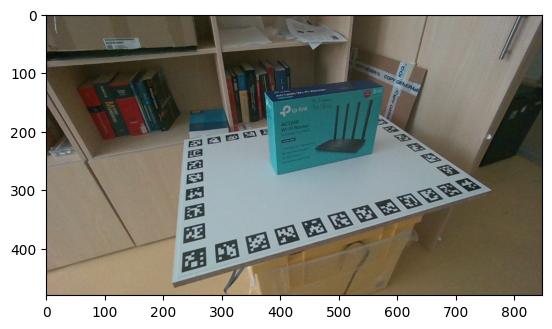

In [73]:
random_image_files = random.sample(image_files, 1)[0]
print(f"Random image files: {random_image_files}")
random_image = cv2.imread(str(random_image_files))
cv2_imshow(random_image)

## Tag detector

This custom made board was made with AprilTags, more specifically with the AprilTag 36h11. The tags are placed at predefined positions. These Tags are designed to be easily and accurately detected. 
In this workshop we will use OpenCV's implementation of the AprilTag detector.

In [74]:
params = cv2.aruco.DetectorParameters()
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36H11)
detector = cv2.aruco.ArucoDetector(aruco_dict, params)

In [79]:
gray_image = cv2.cvtColor(random_image, cv2.COLOR_BGR2GRAY)
corners, tag_ids, rejected = detector.detectMarkers(gray_image)
num_tags = len(tag_ids)
print(f"Detected {num_tags} tags")


Detected 19 tags


We can visualize the tags in the image.

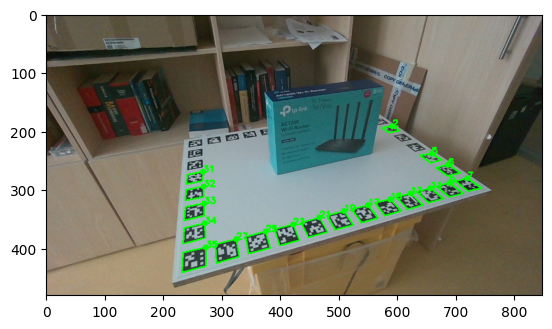

In [82]:
detected_image = visualize_tag_detection(
    random_image, corners, tag_ids, color=(0, 255, 0), width=2
)
cv2_imshow(detected_image)

We can also visual the suspected tags which were not detected.

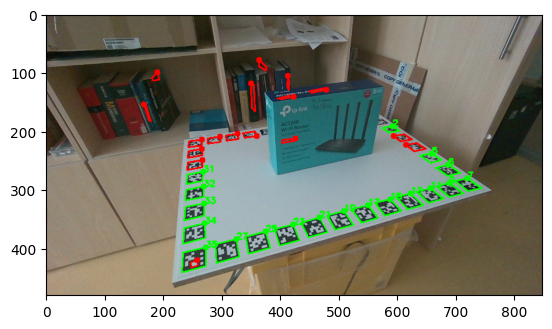

In [83]:
detected_image = visualize_tag_detection(
    detected_image, rejected, color=(0, 0, 255), width=2
)
cv2_imshow(detected_image)

## Establishing correspondecies between image and world space
Now we query by the tag ids into the dictionary and retrieve their corners 3D positions. 
The board is a dictionary in following format:
```python
board = {
  "tag_size_mm": 50,
  "paper_size_mm": [
    841,
    594,
    0
  ],
  "num_x": 8,
  "num_y": 12,
  "<tag_id>": [
    [
      top_left_x,
      top_left_y,
      top_right_z,
    ],
    [
      top_right_x,
      top_right_y,
      top_right_z,
    ],
    [
      bottom_left_x,
      bottom_left_y,
      bottom_left_z,
    ],
    [
      bottom_right_x,
      bottom_right_y,
      bottom_right_z,
    ]
  ],
  "<tag_id>": ...
}
```

In [ ]:
# Load the board data
board_data_path = "data/board/board_centered_rotated_mm.json"
with open(board_data_path, "r") as f:
    board_data = json.load(f)

# Convert the corners to a numpy array
corners_image_pts = np.array(corners).reshape(-1, 2)
# Preallocate the array for the world points
corners_world_pts = np.zeros((num_tags * 4, 3), dtype=np.float32)

for e, tag_id in enumerate(tag_ids):
    i = tag_id[0]
    # Query into the board data
    corners_world_pts[e * 4 : (e + 1) * 4, :] = np.array(board_data[str(i)]).reshape(
        -1, 3
    )

## Perspective-n-Point (PnP) problem
The correspondencies between the image and world space are used to determine the camera pose by solving the Perspective-n-Point (PnP) problem.
To solve this we also need to know the camera behavior, described by the intrinsic parameters and distortion coefficients.


In [ ]:
path2camera_matrix = r"data/camera_params.json"
with open(path2camera_matrix, "r") as f:
    camera_params = json.load(f)["color"]

Kmx = np.array(camera_params["Kmx"])
dist_coeffs = np.array(camera_params["coeffs"])

ret, rvec, tvec = ret, rvec, tvec = cv2.solvePnP(
    corners_world_pts,
    corners_image_pts,
    Kmx,
    dist_coeffs,
    flags=cv2.SOLVEPNP_ITERATIVE,
)
if not ret:
    print("Failed to solve PnP")

## 6D Pose
There are multiple ways how to store the 6D pose of arbitrary object. Most common way is to use a 4x4 matrix, which contains the tranlation vector $\mathbf{t}$ and the rotation matrix $\mathbf{R}$. The rotation matrix is a 3x3 matrix, which describes the orientation in space. The translation vector is a 3x1 vector, which contains the position (x,y,z) of the object in space. The 4x4 matrix is constructed as follows:
$$
\mathbf{T} = \begin{bmatrix}
\mathbf{R} & \mathbf{t} \\
\mathbf{o}^\mathrm{T} & 1
\end{bmatrix}
$$

Other common way is to use a rotation vector $\mathbf{r}$, or a quaternion $\mathbf{q}$. The rotation vector is a 3x1 vector, which contains the axis of rotation(unit 3x1 vector) and the angle of rotation(scalar). The quaternion is a 4x1 vector, which contains the axis of rotation and the angle of rotation.

As part of this workshop we will be using a 4x4 matrix as although it is not the most efficient way of storing the pose. It is commonly used in computer vision and can be used directly to transform points from one coordinate system to another. 


In [89]:
Tmx = np.eye(4, dtype=np.float32)
Tmx[:3, :3] = cv2.Rodrigues(rvec)[0]
Tmx[:3, 3] = tvec.flatten()
Tmx = np.linalg.inv(Tmx)
print(f"Camera Tmx: {Tmx}")

Camera Tmx: [[-9.5032436e-01  1.8312554e-01 -2.5169173e-01  2.7014178e+02]
 [ 3.1102636e-01  5.2726400e-01 -7.9073083e-01  6.3753235e+02]
 [-1.2095021e-02 -8.2973349e-01 -5.5802870e-01  4.8046597e+02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


## Visualization of the results

TODO: Test this function in COLAB

In [ ]:
board_mesh = create_board_mesh("data/board/board.png", np.array(board_data["paper_size_mm"]))
camera_mesh_list = create_camera_pyramid(
    random_image, Kmx, Tmx, name="camera"   )
o3d.visualization.draw([board_mesh].extend(camera_mesh_list))

Board size: [841 594   0]
Half size: [420.5 297.    0. ]
[Open3D INFO] Window window_0 created.
[Open3D INFO] EGL headless mode enabled.
[Open3D INFO] ICE servers: ["stun:stun.l.google.com:19302", "turn:user:password@34.69.27.100:3478", "turn:user:password@34.69.27.100:3478?transport=tcp"]
FEngine (64 bits) created at 0x7f2605042010 (threading is enabled)
[Open3D INFO] Set WEBRTC_STUN_SERVER environment variable add a customized WebRTC STUN server.
[Open3D INFO] WebRTC Jupyter handshake mode enabled.
EGL(1.5)
OpenGL(4.1)


KeyboardInterrupt: 

# Now we need to do this for every single image

Now we need to repeat the process for all of the images.


In [98]:
camera_poses = []
for e, image_file in enumerate(tqdm(image_files)):

    bgr = cv2.imread(str(image_file))
    gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

    corners, ids, rejected = detector.detectMarkers(gray)


    num_tags = len(corners)

    print(f"Number of tags detected: {num_tags}")
    if num_tags == 0:
        print(f"No tags detected in image {str(image_file)}")
        continue
    
    corners_image_pts = np.array(corners).reshape(-1, 2)
    corners_world_pts = np.zeros((num_tags * 4, 3), dtype=np.float32)
    
    for e, tag_id in enumerate(ids):
        i = tag_id[0]
        # Query into the board data
        corners_world_pts[e * 4 : (e + 1) * 4, :] = np.array(
            board_data[str(i)]
        ).reshape(-1, 3)

        ret, Rvec, tvec = ret, rvec, tvec = cv2.solvePnP(
        corners_world_pts,
        corners_image_pts,
        Kmx,
        dist_coeffs,
        flags=cv2.SOLVEPNP_ITERATIVE,
    )
        
    if not ret:
        print("Failed to solve PnP")
        continue
    
    Tmx = np.eye(4, dtype=np.float32)
    Tmx[:3, :3] = cv2.Rodrigues(Rvec)[0]
    Tmx[:3, 3] = tvec.reshape(-1)

    Tmx = np.linalg.inv(Tmx)

    camera_data = {
        "file_path": str(image_file),
        "transform_matrix": Tmx.tolist(),

    }
    camera_poses.append(camera_data)

    img2show = visualize_tag_detection(
        bgr,
        corners,
        ids,
        color=(0, 255, 0),
        width=2,
    )


100%|██████████| 5/5 [00:00<00:00, 37.56it/s]

Number of tags detected: 19
Number of tags detected: 19
Number of tags detected: 24
Number of tags detected: 23
Number of tags detected: 34


# Conversion to the iNGP format
Up until now we worked with camera notation from OpenCV. However in computer graphics a OpenGL notation is also commonly used.



| OpenCV | OpenGL |
|:-------------------------:|:-------------------------:|
| <img width="1604" alt="OpenCV" src="https://github.com/vitzeman/manim_vis/blob/main/visualization/MSV-Workshop/OpenCV.png?raw=true">|<img width="1604" alt="OpenGL" src="https://github.com/vitzeman/manim_vis/blob/main/visualization/MSV-Workshop/OpenGL.png?raw=true">|



These two notation differ in the way how the cameras frames are defined. The x axis stays the same, and the two frame differ in the y and z axis. In OpenCV the y axis is pointing down, while in OpenGL it is pointing up. The z axis is also flipped.
The transformation between these two frames is described as rotation by 180 degrees around the x axis, which can be described as transformation matrix: 
$$
\mathbf{T} = \begin{bmatrix}
1 & 0 & 0 & 0 \\
0 & -1 & 0 & 0 \\
0 & 0 & -1 & 0 \\
0 & 0 & 0 & 1
\end{bmatrix}
$$
We can chain this transformation with previously obtained camera pose to obtain the desired camera pose in OpenGL notation.
The transformation matrix is applied to the camera pose matrix as follows:

